In [1]:
import os
import json
import time
import random
import numpy as np
import pandas as pd
import openml
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import StatevectorSampler, Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.gradients import (
    ParamShiftSamplerGradient,
    SPSASamplerGradient,
)
from qiskit.transpiler import PassManager

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

from utils.data.preprocessing import data_pipeline

In [2]:
def set_seed(seed):
    """Set the random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [3]:
def print_class_distribution(y_tensor, name):
    values, counts = torch.unique(y_tensor, return_counts=True)
    total = counts.sum().item()
    print(f"{name} class distribution:")
    for v, c in zip(values.tolist(), counts.tolist()):
        pct = 100 * c / total
        print(f"  Class {v}: {c} samples ({pct:.2f}%)")
    print()

In [4]:
def plot_classification_results(
    X,
    y_true,
    y_pred,
    cmap_name="tab10",
    point_size=60,
    mistake_size=200,
    mistake_edgecolor="r",
):
    """
    X         : array_like, shape (N,2) — 2D inputs
    y_true    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    y_pred    : array_like, shape (N,)  — integer labels 0..(n_classes–1)
    cmap_name : matplotlib colormap name for up to 10 classes (e.g. 'tab10','tab20')
    """
    X = np.asarray(X)
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    assert X.shape[0] == y_true.shape[0] == y_pred.shape[0]
    n_classes = len(np.unique(y_true))

    # discrete colormap with exactly n_classes entries
    cmap = plt.get_cmap(cmap_name, n_classes)

    fig, ax = plt.subplots(figsize=(6, 6))
    # plot all points, color by true label
    sc = ax.scatter(
        X[:, 0], X[:, 1], c=y_true, cmap=cmap, s=point_size, edgecolors="k", alpha=0.8
    )

    # highlight mistakes
    mask = y_true != y_pred
    if mask.any():
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            s=mistake_size,
            facecolors="none",
            edgecolors=mistake_edgecolor,
            linewidths=2,
            label="misclassified",
        )

    # optional legend / colorbar
    if n_classes <= 10:
        # show discrete legend
        handles, _ = sc.legend_elements(prop="colors")
        labels = list(range(n_classes))
        ax.legend(handles, labels, title="class")
    else:
        # fallback to continuous colorbar
        plt.colorbar(sc, ticks=range(n_classes), label="true class")

    ax.set_xlabel("x₀")
    ax.set_ylabel("x₁")
    ax.set_title(f"{n_classes}-class scatter (red holes = mistakes)")
    plt.show()

In [5]:
def results_exporter(
    model: nn.Module,
    seed: int = 42,
    model_type: str = "quantum",
    ansatz: str = None,
    dataset_name: str = "iris",
    batch_size: int = 32,
    epochs: int = 10,
    average_time_per_epoch: float = 0.0,
    input_dim: int = 4,
    depth: int = 0,
    num_classes: int = 3,
    test_metrics: dict = None,
    circuit_fp: str = None,
    params_fp: str = None,
    save_csv: str = "./results/baseline_results.csv",
):
    if os.path.exists(save_csv):
        results_df = pd.read_csv(save_csv)
    else:
        results_df = pd.DataFrame(
            columns=[
                "datetime",
                "seed",
                "model_type",
                "dataset_name",
                "ansatz",
                "batch_size",
                "epochs",
                "average_time_per_epoch",
                "input_dim",
                "depth",
                "num_classes",
                "train_acc",
                "train_prec",
                "train_rec",
                "train_f1",
                "train_losses",
                "val_acc",
                "val_prec",
                "val_rec",
                "val_f1",
                "val_losses",
                "test_acc",
                "test_prec",
                "test_rec",
                "test_f1",
                "test_loss",
                "circuit_fp",
                "params_fp",
            ]
        )
        results_df.to_csv(save_csv, index=False)
        return False

    train_losses = json.dumps(
        [round(loss, 4) for loss in model.history.get("train_loss", [])]
    )
    val_losses = json.dumps(
        [round(loss, 4) for loss in model.history.get("val_loss", [])]
    )

    new_row = {
        "datetime": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        "seed": seed,
        "model_type": model_type,
        "ansatz": ansatz if ansatz else None,
        "dataset_name": dataset_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "average_time_per_epoch": round(average_time_per_epoch, 4),
        "input_dim": input_dim,
        "depth": depth if model_type == "quantum" else 0,
        "num_classes": num_classes,
        "train_acc": round(model.history["train_acc"][-1], 4),
        "train_prec": round(model.history["train_prec"][-1], 4),
        "train_rec": round(model.history["train_rec"][-1], 4),
        "train_f1": round(model.history["train_f1"][-1], 4),
        "train_losses": train_losses,
        "val_acc": round(model.history["val_acc"][-1], 4),
        "val_prec": round(model.history["val_prec"][-1], 4),
        "val_rec": round(model.history["val_rec"][-1], 4),
        "val_f1": round(model.history["val_f1"][-1], 4),
        "val_losses": val_losses,
        "test_acc": round(test_metrics["test_acc"], 4) if test_metrics else None,
        "test_prec": round(test_metrics["test_prec"], 4) if test_metrics else None,
        "test_rec": round(test_metrics["test_rec"], 4) if test_metrics else None,
        "test_f1": round(test_metrics["test_f1"], 4) if test_metrics else None,
        "test_loss": round(test_metrics["test_loss"], 4) if test_metrics else None,
        "circuit_fp": circuit_fp if circuit_fp else None,
        "params_fp": params_fp if params_fp else None,
    }

    new_row_df = pd.DataFrame([new_row])
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)

    # Save
    results_df.to_csv(save_csv, index=False)
    print(f"Results saved to {save_csv}")
    return True

# Main


## Weight Extraction


## TODO:
- global configs
- dynamically name the results file based on environment
- GPU support
- main.py

In [6]:
from utils.nn.ClassicalNN import ClassicalNN, FlexibleNN
from utils.nn.QuantumNN import QuantumNN

import utils.ansatze.AnsatzExtractor as AnsatzExtractor

from utils.ansatze.HEA import HEA
from utils.ansatze.RealAmplitudes import RealAmplitudeAnsatz
from utils.ansatze.RandomPQC import RandomPQCAnsatz
from utils.ansatze.MPS import MPSAnsatz
from utils.ansatze.TTN import TTNAnsatz
from utils.ansatze.WIPQC import WeightInformedPQCAnsatz

In [7]:
CLASS_MAP = {
    "HEA": HEA,
    "WeightInformedPQCAnsatz": WeightInformedPQCAnsatz,
    "RealAmplitudeAnsatz": RealAmplitudeAnsatz,
    "RandomPQCAnsatz": RandomPQCAnsatz,
    "MPSAnsatz": MPSAnsatz,
    "TTNAnsatz": TTNAnsatz,
}

BUILDER_FUNC_MAP = {
    "get_initial_point_builder": lambda ansatz_obj: {"initial_point": ansatz_obj.get_initial_point()}
    # Add other builders if you have more
}

def load_ansatz_configurations(json_file_path: Path, input_dim: int, DEPTH: int, model_c_instance: object = None) -> list:
    with open(json_file_path, 'r') as f:
        raw_configs = json.load(f)

    processed_configs = []
    for cfg in raw_configs:
        # Map class string to actual class
        cfg["class"] = CLASS_MAP[cfg.pop("class_str")]

        # Inject runtime values into init_args
        if "n_qubits_from_input_dim" in cfg["init_args"] and cfg["init_args"].pop("n_qubits_from_input_dim", False): # Add default to pop
             cfg["init_args"]["n_qubits"] = input_dim

        if "n_qubits" in cfg["init_args"]:
            cfg["init_args"]["n_qubits"] = input_dim
        elif cfg["class"] in [HEA, RealAmplitudeAnsatz, RandomPQCAnsatz, MPSAnsatz, TTNAnsatz]: # Classes that always need n_qubits
            if "n_qubits" not in cfg["init_args"]:
                cfg["init_args"]["n_qubits"] = input_dim

        if "depth" in cfg["init_args"] and cfg["init_args"]["depth"] == "DEPTH":
            cfg["init_args"]["depth"] = DEPTH

        if "classical_model" in cfg["init_args"]:
            cfg["init_args"]["classical_model"] = model_c_instance

        if "ent_top_k" in cfg["init_args"]:
            if cfg["init_args"]["ent_top_k"] is None:
                cfg["init_args"]["ent_top_k"] = None
            if cfg["init_args"]["ent_top_k"] == "HALF":
                cfg["init_args"]["ent_top_k"] = input_dim // 2
            else:
                try:
                    cfg["init_args"]["ent_top_k"] = int(cfg["init_args"]["ent_top_k"])
                except ValueError as e:
                    print(f"[WARNING]: Error converting ent_top_k to int: {e}")
                    cfg["init_args"]["ent_top_k"] = None

        # Map qnn_extra_args_builder string to actual function
        builder_str = cfg.pop("qnn_extra_args_builder_str", None)
        if builder_str:
            cfg["qnn_extra_args_builder"] = BUILDER_FUNC_MAP[builder_str]

        processed_configs.append(cfg)
    return processed_configs

In [8]:
import getpass

def get_environment_identifier():
    user = getpass.getuser()
    machine_id = os.uname().machine  # or platform.node()
    raw = f"{user}-{machine_id}"
    return raw

def create_environment_results_directory(env_id: str, base_path: str = "./results/") -> Path:
    """
    Create a directory for storing results based on the current environment.
    """
    results_dir = Path(base_path) / env_id
    results_dir.mkdir(parents=True, exist_ok=True)
    return results_dir

get_environment_identifier()

'larryhh-arm64'

In [9]:
# --- Experiment Configurations ---

USE_GPU = True

SEEDS = [1, 2, 3, 4]  # For reproducibility

DATASET_NAMES = ["iris", "wine", "diabetes"]  # "diabetes" # Add or modify as needed
OPENML_DATASET_IDS = {
    "iris": (61, 4),
    "wine": (187, 13),
    "diabetes": (37, 8),
}

# Common training parameters
DO_PCA = True
DEPTH = 2
N_COMPONENTS = [4, 6]  # Used if DO_PCA is True
BATCH_SIZE = 32
EPOCHS_CLASSICAL = 100  # Reduced for quick testing; use your value e.g., 100
EPOCHS_QUANTUM = 30  # Reduced for quick testing; use your value e.g., 50
CLASSICAL_LR = 0.01
QUANTUM_LR = 0.05

ENV_ID = get_environment_identifier()
# Create results directory based on environment identifier
RESULTS_DIR = create_environment_results_directory(ENV_ID)
RESULTS_CSV_FILE = RESULTS_DIR / "wi_experiment.csv"  # Results CSV file path
SCHEMA_OUTPUT_DIR = RESULTS_DIR / "schemas"  # Directory for saving schemas

LOAD_IN_CLASSICAL = False  # Whether to load classical model from file if exists

os.makedirs(os.path.dirname(RESULTS_CSV_FILE), exist_ok=True)
os.makedirs(SCHEMA_OUTPUT_DIR, exist_ok=True)

# --- Main Experiment Loop ---
if __name__ == "__main__":
    for seed in SEEDS:  # Outer loop for seed
        for n_components_for_pca in N_COMPONENTS:  # Outermost loop for PCA components
            print(
                f"\n{'#'*25} RUNNING EXPERIMENTS WITH PCA N_COMPONENTS = {n_components_for_pca} {'#'*25}"
            )

            for dataset_name in DATASET_NAMES:
                print(f"\n{'='*20} PROCESSING DATASET: {dataset_name.upper()} {'='*20}")
                openml_dataset_id = OPENML_DATASET_IDS[dataset_name][0]
                n_features = OPENML_DATASET_IDS[dataset_name][1]

                if n_components_for_pca > n_features:
                    print(
                        f"[SKIP] Skipping {dataset_name} with n_components={n_components_for_pca} as it exceeds the number of features ({n_features})."
                    )
                    continue
                    
                # 1. Load and preprocess data
                print("\n[INFO] Loading data...")
                classical_data, quantum_data, input_dim, output_dim, is_multiclass = (
                    data_pipeline(
                        openml_dataset_id,
                        batch_size=BATCH_SIZE,
                        do_pca=DO_PCA,
                        n_components=n_components_for_pca,
                        seed=seed,
                    )
                )

                (
                    x_train_c,
                    x_val_c,
                    x_test_c,
                    y_train_c,
                    y_val_c,
                    y_test_c,
                    train_loader_c,
                    val_loader_c,
                    test_loader_c,
                ) = classical_data
                (
                    x_train_q,
                    x_val_q,
                    x_test_q,
                    y_train_q,
                    y_val_q,
                    y_test_q,
                    train_loader_q,
                    val_loader_q,
                    test_loader_q,
                ) = quantum_data

                print_class_distribution(y_train_c, f"{dataset_name} - Train")
                print_class_distribution(y_val_c, f"{dataset_name} - Validation")
                print_class_distribution(y_test_c, f"{dataset_name} - Test")

                schema_file_base = os.path.join(
                    SCHEMA_OUTPUT_DIR, f"{dataset_name}/seed_{seed}/"
                )
                os.makedirs(os.path.dirname(schema_file_base), exist_ok=True)

                # 2. Classical Model Baseline
                print(f"\n[INFO] Training Classical Baseline for {dataset_name}...")
                set_seed(seed)

                if LOAD_IN_CLASSICAL:
                    model_state_fp = os.path.join(schema_file_base, f"classical_nn_{input_dim}q_{DEPTH}d.pth")
                    if os.path.exists(model_state_fp):
                        model_c = FlexibleNN.get_model_from_state_dict(model_state_fp)
                        model_c.set_history_to_zero_for_loaded_model()
                        test_metrics_c_dict = {
                            "test_acc": 0.0,
                            "test_loss": 0.0
                        }
                        avg_time_epoch_c = 0.0 

                    else:
                        raise FileNotFoundError(
                            f"Classical model file not found at {model_state_fp}. Please ensure the model is trained and saved."
                        )
                else:
                    model_c = FlexibleNN(
                        input_dim=input_dim,
                        hidden_dims=[input_dim] * DEPTH,  # DEPTH hidden layers of size n_qubits
                        output_dim=output_dim,  # Output layer with 2 features
                        act="relu",
                        condition_number=0.0,  # No condition number scaling
                        scale_on_export=False,
                        use_gpu=USE_GPU,
                    )

                    optimizer_c = optim.Adam(model_c.parameters(), lr=CLASSICAL_LR)

                    start_time_c = time.time()
                    model_c.fit(
                        train_loader_c,
                        val_loader_c,
                        epochs=EPOCHS_CLASSICAL,
                        optimizer=optimizer_c,
                        verbose=False,
                    )  # Set verbose as needed
                    end_time_c = time.time()
                    avg_time_epoch_c = (
                        (end_time_c - start_time_c) / EPOCHS_CLASSICAL
                        if EPOCHS_CLASSICAL > 0
                        else 0
                    )

                    torch.save(
                        model_c.state_dict(),
                        os.path.join(schema_file_base, f"classical_nn_{input_dim}q_{DEPTH}d.pth"),
                    )

                eval_output_c = model_c.evaluate(
                    test_loader_c, verbose=False
                )  # avg_loss, acc, prec, recall, f1, y_pred, y_true
                test_metrics_c_dict = {
                    "test_acc": eval_output_c[1],
                    "test_loss": eval_output_c[0],
                    "test_prec": eval_output_c[2],
                    "test_rec": eval_output_c[3],
                    "test_f1": eval_output_c[4]
                }
                print(
                    f"Classical Test Results: Loss={test_metrics_c_dict['test_loss']:.4f}, Acc={test_metrics_c_dict['test_acc']:.4f}, F1={eval_output_c[4]:.4f}"
                )

                results_exporter(
                    model_c,
                    seed=seed,
                    model_type="classical",
                    ansatz=None,  # No ansatz for classical model
                    dataset_name=dataset_name,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS_CLASSICAL,
                    average_time_per_epoch=avg_time_epoch_c,
                    input_dim=input_dim,
                    depth=0,  # Classical model depth is 0
                    num_classes=output_dim,
                    test_metrics=test_metrics_c_dict,
                    circuit_fp=None,  # No circuit for classical model
                    params_fp=None,  # No params for classical model
                    save_csv=RESULTS_CSV_FILE,
                )

                base_configs_path = Path("./ansatze_configs.json") # Or your actual path

                ansatz_configurations = load_ansatz_configurations(base_configs_path, input_dim, DEPTH, model_c_instance=model_c)
                if input_dim not in [2**i for i in range(1, 6)]:
                    ansatz_configurations = [cfg for cfg in ansatz_configurations if "TTN" not in cfg["name"]]

                for config in ansatz_configurations:
                    ansatz_name = config["name"]
                    AnsatzClass = config["class"]
                    init_args = config["init_args"]

                    print(
                        f"\n[INFO] Setting up Quantum Model with {ansatz_name} Ansatz for {dataset_name}..."
                    )

                    print(f"[INFO] Ansatz Class: {AnsatzClass.__name__}")
                    print(f"[INFO] Ansatz Init Args: {init_args}")

                    # Instantiate ansatz
                    current_ansatz = AnsatzClass(**init_args)
                    # current_ansatz.draw() # Optional: draw each ansatz

                    # Get QNN initialization parameters
                    qnn_init_dict = {
                        "ansatz": current_ansatz.get_ansatz(),
                        "n_qubits": input_dim,
                        "num_classes": output_dim,
                    }
                    if "qnn_extra_args_builder" in config:  # For WI-PQC initial_point
                        qnn_init_dict.update(
                            config["qnn_extra_args_builder"](current_ansatz)
                        )
                    elif "qnn_extra_args" in config:
                        qnn_init_dict.update(config["qnn_extra_args"])

                    set_seed(seed)  # Reset seed for each ansatz
                    model_q = QuantumNN(**qnn_init_dict, use_gpu=USE_GPU)

                    print(f"[INFO] Extracting schema for {ansatz_name}...")
                    circuit_fp = os.path.join(
                        schema_file_base,
                        f"{ansatz_name}_{n_components_for_pca}q_circuit.qpy",
                    )
                    params_fp = os.path.join(
                        schema_file_base,
                        f"{ansatz_name}_{n_components_for_pca}q_params.json",
                    )

                    AnsatzExtractor.extract_and_store_model_schema(
                        current_ansatz,
                        model_q,  # Pass the (possibly trained) model_q if weights are desired
                        circuit_fp,
                        params_fp,
                    )

                    # Optimizer and Scheduler for Quantum Model
                    optimizer_q = optim.Adam(model_q.parameters(), lr=QUANTUM_LR)
                    scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer_q,
                        mode="min",
                        factor=0.3,
                        patience=max(1, EPOCHS_QUANTUM // 5),
                        min_lr=1e-4,
                        verbose=False,
                    )

                    print(f"[INFO] Training Quantum Model ({ansatz_name})...")
                    start_time_q = time.time()
                    model_q.fit(
                        train_loader_q,
                        val_loader_q,
                        epochs=EPOCHS_QUANTUM,
                        optimizer=optimizer_q,
                        scheduler=scheduler_q,
                        verbose=False,
                    )  # Set verbose
                    end_time_q = time.time()
                    avg_time_epoch_q = (
                        (end_time_q - start_time_q) / EPOCHS_QUANTUM
                        if EPOCHS_QUANTUM > 0
                        else 0
                    )

                    eval_output_q = model_q.evaluate(test_loader_q, verbose=False)
                    test_metrics_q_dict = {
                        "test_acc": eval_output_q[1],
                        "test_loss": eval_output_q[0],
                        "test_prec": eval_output_q[2],
                        "test_rec": eval_output_q[3],
                        "test_f1": eval_output_q[4]
                    }
                    print(
                        f"{ansatz_name} Test Results: Loss={test_metrics_q_dict['test_loss']:.4f}, Acc={test_metrics_q_dict['test_acc']:.4f}, F1={eval_output_q[4]:.4f}"
                    )

                    exporter_depth_val = 0  # Default
                    if hasattr(current_ansatz, "depth"):
                        exporter_depth_val = current_ansatz.depth
                    elif hasattr(current_ansatz, "get_depth"):
                        exporter_depth_val = current_ansatz.get_depth()

                    results_exporter(
                        model_q,
                        seed=seed,
                        model_type="quantum",
                        ansatz=ansatz_name,
                        dataset_name=dataset_name,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS_QUANTUM,
                        average_time_per_epoch=avg_time_epoch_q,
                        input_dim=input_dim,
                        depth=exporter_depth_val,
                        num_classes=output_dim,
                        test_metrics=test_metrics_q_dict,
                        circuit_fp=circuit_fp,
                        params_fp=params_fp,
                        save_csv=RESULTS_CSV_FILE,
                    )

                print(f"\n{'='*20} COMPLETED DATASET: {dataset_name.upper()} {'='*20}")

            print("\n[INFO] Experiment finished.")


######################### RUNNING EXPERIMENTS WITH PCA N_COMPONENTS = 4 #########################

==================== PROCESSING DATASET: IRIS ====================

[INFO] Loading data...
Dataset name: iris
Total features: 4, Dropped Categorical features: 0, Remaining features: 4
Classical data reduced to 4 dimensions using PCA.
Quantum data reduced to 4 dimensions using PCA.
iris - Train class distribution:
  Class 0: 29 samples (32.95%)
  Class 1: 30 samples (34.09%)
  Class 2: 29 samples (32.95%)

iris - Validation class distribution:
  Class 0: 9 samples (31.03%)
  Class 1: 10 samples (34.48%)
  Class 2: 10 samples (34.48%)

iris - Test class distribution:
  Class 0: 10 samples (33.33%)
  Class 1: 10 samples (33.33%)
  Class 2: 10 samples (33.33%)


[INFO] Training Classical Baseline for iris...
GPU not available, falling back to CPU.
Initialized FlexibleNN on device: cpu
Classical Test Results: Loss=0.0678, Acc=0.9333, F1=0.9327
Results saved to results/larryhh-arm64/wi_experim

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
raise

RuntimeError: No active exception to reraise

# Load Results


In [ ]:
import ast
import re

In [ ]:
def get_after_datetime(df: pd.DataFrame, start_datetime_str: str, end_datetime_str: str | None) -> pd.DataFrame:
    df['datetime'] = pd.to_datetime(df['datetime'])
    # get rows between start and end datetime
    start_datetime = pd.to_datetime(start_datetime_str)
    if end_datetime_str:    
        end_datetime = pd.to_datetime(end_datetime_str)
        return df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
    else:
        return df[df['datetime'] >= start_datetime]

def ignore_ansatze(df: pd.DataFrame, substrings: list[str]) -> pd.DataFrame:
    patt = "|".join(map(re.escape, substrings))
    mask = df["ansatz"].str.contains(patt, case=False, regex=True, na=False)
    return df[~mask]


In [ ]:
datasets   = ["iris", "wine", "diabetes"]
input_dims = [2, 4, 6, 8]

wi_results_fp = "results/wi_experiment.csv"
if os.path.exists(wi_results_fp):
    wi_results_df = pd.read_csv(wi_results_fp)

wi_results_df = get_after_datetime(wi_results_df, "2025-06-03", "2025-06-07")
wi_results_df = ignore_ansatze(wi_results_df, ["Random PQC", "Real Amplitudes", "MPS", "TTN", "HEA (x, y, z)"])

# nested dict: results[dataset][n_qubits] → filtered DataFrame
results = {
    d: {
        q: grp.query("input_dim == @q")
        for q in input_dims
    }
    for d, grp in (
        wi_results_df[wi_results_df["model_type"].str.contains("quantum", na=False)]
        .groupby("dataset_name")
    ) if d in datasets
}

iris_results_2q = results["iris"][2]
iris_results_4q = results["iris"][4]

wine_results_2q = results["wine"][2]
wine_results_4q = results["wine"][4]
wine_results_6q = results["wine"][6]
wine_results_8q = results["wine"][8]

diabetes_results_2q = results["diabetes"][2]
diabetes_results_4q = results["diabetes"][4]
diabetes_results_6q = results["diabetes"][6]
diabetes_results_8q = results["diabetes"][8]

In [ ]:
iris_results_2q

,datetime,seed,model_type,dataset_name,ansatz,batch_size,epochs,average_time_per_epoch,input_dim,depth,num_classes,train_acc,val_acc,test_acc,test_loss,train_losses,val_losses,circuit_fp,params_fp
305,2025-06-04 17:10:20,0,quantum,iris,"HEA (y, z)",32,30,1.2310,2,2,3,0.7841,0.7586,0.7667,0.6366,"[1.3889, 1.2655, 1.1434, 1.0271, 0.9207, 0.841...","[1.3179, 1.2068, 1.0837, 0.9839, 0.8947, 0.834...","./results/schemas/iris/seed_0/HEA (y, z)_2q_ci...","./results/schemas/iris/seed_0/HEA (y, z)_2q_pa..."
307,2025-06-04 17:12:03,0,quantum,iris,WI-PQC (E),32,30,1.3615,2,0,3,0.7727,0.7586,0.7667,0.6290,"[1.6871, 1.327, 1.1241, 1.0193, 0.9416, 0.9063...","[1.4519, 1.0948, 0.9532, 0.8802, 0.8628, 0.878...",./results/schemas/iris/seed_0/WI-PQC (E)_2q_ci...,./results/schemas/iris/seed_0/WI-PQC (E)_2q_pa...
308,2025-06-04 17:12:45,0,quantum,iris,"WI-PQC (W+E, chunking)",32,30,1.3744,2,0,3,0.7273,0.7931,0.6667,0.6736,"[2.0186, 1.7978, 1.6796, 1.5824, 1.4941, 1.491...","[1.8968, 2.5086, 1.6416, 1.6208, 1.4933, 1.537...","./results/schemas/iris/seed_0/WI-PQC (W+E, chu...","./results/schemas/iris/seed_0/WI-PQC (W+E, chu..."
309,2025-06-04 17:13:27,0,quantum,iris,"WI-PQC (W+E, svd)",32,30,1.4006,2,0,3,0.1136,0.1034,0.1000,1.8088,"[2.3046, 2.2564, 2.1528, 1.9499, 1.827, 1.7698...","[2.1477, 2.1064, 2.0387, 1.9117, 1.8297, 1.789...","./results/schemas/iris/seed_0/WI-PQC (W+E, svd...","./results/schemas/iris/seed_0/WI-PQC (W+E, svd..."
310,2025-06-04 17:14:27,0,quantum,iris,"WI-PQC (W1+W2+E, chunking)",32,30,2.0157,2,0,3,0.3068,0.3793,0.1000,1.8336,"[2.0189, 1.7411, 1.6488, 1.6743, 1.6599, 1.641...","[1.853, 1.6795, 1.5857, 1.5039, 1.4452, 1.4258...","./results/schemas/iris/seed_0/WI-PQC (W1+W2+E,...","./results/schemas/iris/seed_0/WI-PQC (W1+W2+E,..."
311,2025-06-04 17:15:27,0,quantum,iris,"WI-PQC (W1+W2+E, svd)",32,30,1.9882,2,0,3,0.2045,0.1379,0.1667,1.8538,"[2.4733, 2.4421, 2.6126, 2.3625, 2.871, 2.3327...","[2.372, 2.2399, 2.2161, 2.2521, 2.3492, 2.2654...","./results/schemas/iris/seed_0/WI-PQC (W1+W2+E,...","./results/schemas/iris/seed_0/WI-PQC (W1+W2+E,..."


In [ ]:
def print_expr(df):
    print(f"\n{'#'*20} RESULTS FOR {df['dataset_name'].iloc[0].upper()} ({df['input_dim'].iloc[0]} QUBITS) {'#'*20}")
    print("Train Acc | Validation Acc | Test Acc")
    _df = df.copy()
    _df = _df.sort_values(by=["train_acc", "val_acc", "test_acc"], ascending=False)
    for i, row in _df.iterrows():
        print(
            f"{row['ansatz']}: {row['train_acc']:.4f} | {row['val_acc']:.4f} | {row['test_acc']:.4f}"
        )

In [ ]:
import ast
import matplotlib.pyplot as plt


def plot_loss_results_horizontal(dataset_df, highlight_keyword="wi-pqc"):
    """
    Plots training and validation loss curves side-by-side (horizontally).

    Args:
        dataset_df (pd.DataFrame): DataFrame containing the results.
                                   Expected columns: 'train_losses', 'val_losses',
                                   'model_type', 'dataset_name', 'input_dim'.
                                   'train_losses' and 'val_losses' should be
                                   string representations of lists or actual lists.
        highlight_keyword (str): Keyword in 'model_type' to highlight in the plot.
    """

    def safe_eval(x):
        if isinstance(x, list):
            return x
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except (ValueError, SyntaxError) as e:
                print(f"Warning: Could not parse string: {x}. Error: {e}")
                return []  # Return empty list or handle as appropriate
        # If x is already a list (e.g. from direct DataFrame creation), return it
        if isinstance(x, (list, tuple)):
            return list(x)
        print(
            f"Warning: Cannot parse losses of type {type(x)} for value {x}. Returning empty list."
        )
        return []

    df = dataset_df.copy()
    # Ensure 'train_losses' and 'val_losses' are lists of numbers
    df["train_losses"] = df["train_losses"].apply(safe_eval)
    df["val_losses"] = df["val_losses"].apply(safe_eval)

    # Filter out rows where losses could not be parsed properly (resulting in empty lists)
    df = df[df["train_losses"].apply(lambda x: len(x) > 0)]
    df = df[df["val_losses"].apply(lambda x: len(x) > 0)]

    if df.empty:
        print("No data to plot after parsing losses.")
        return

    # Create subplots: 1 row, 2 columns. Share the Y-axis.
    # Adjusted figsize for a potentially more compact look
    fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for _, row in df.iterrows():
        name = str(row.get("ansatz", "Unknown Model"))  # Use .get for safety
        is_hi = highlight_keyword.lower() in name.lower()
        lw, alpha = (
            (2.5, 1.0) if is_hi else (1.0, 0.7)
        )  # Adjusted alpha for better visibility
        zorder = 2 if is_hi else 1

        # Ensure there's data to plot for this row
        if not row["train_losses"] or not row["val_losses"]:
            print(f"Skipping {name} due to empty loss data after parsing.")
            continue

        ax_train.plot(
            row["train_losses"], label=name, linewidth=lw, alpha=alpha, zorder=zorder
        )
        ax_val.plot(
            row["val_losses"],
            label=name,  # Label will be used for combined legend
            linewidth=lw,
            alpha=alpha,
            linestyle="--",
            zorder=zorder,
        )

    ax_train.set_title("Training Loss")
    ax_train.set_xlabel("Epoch")
    ax_train.set_ylabel("Loss")
    ax_train.grid(True, linestyle=":", alpha=0.7)  # Lighter grid

    ax_val.set_title("Validation Loss")
    ax_val.set_xlabel("Epoch")
    # ax_val.set_ylabel("Loss") # Not needed due to sharey=True
    ax_val.grid(True, linestyle=":", alpha=0.7)  # Lighter grid

    # ax_train.set_ylim(0.52, 0.65)
    # ax_val.set_ylim(0.52, 0.65)  # Set same Y limits for both plots

    # --- Combined Legend ---
    handles, labels = ax_val.get_legend_handles_labels()

    # Adjust layout to make space for the legend.
    # The `right` parameter controls the right edge of the subplots.
    # Reducing the gap between plots and legend.
    fig.subplots_adjust(
        left=0.08, right=0.82, top=0.88, bottom=0.15, wspace=0.05
    )  # Give more room for suptitle and labels

    # Place legend outside the plots, to the right of the validation plot
    # Adjusted bbox_to_anchor to position it more snugly next to the plots.
    fig.legend(
        handles,
        labels,
        loc="upper left",  # Anchor point of the legend box
        bbox_to_anchor=(0.83, 0.88),  # Position the anchor point (relative to figure)
        borderaxespad=0.1,
        frameon=True,
        fontsize="small",
        title="Model Types",
    )

    dataset_name_str = (
        str(df["dataset_name"].iloc[0]).upper()
        if not df.empty and "dataset_name" in df.columns
        else "Unknown Dataset"
    )
    input_dim_str = (
        str(df["input_dim"].iloc[0])
        if not df.empty and "input_dim" in df.columns
        else "N/A"
    )

    fig.suptitle(
        f"Loss Curves for {dataset_name_str} ({input_dim_str} Qubits)",
        fontsize=16,
        y=0.97,
    )  # Adjusted y for suptitle

    plt.show()

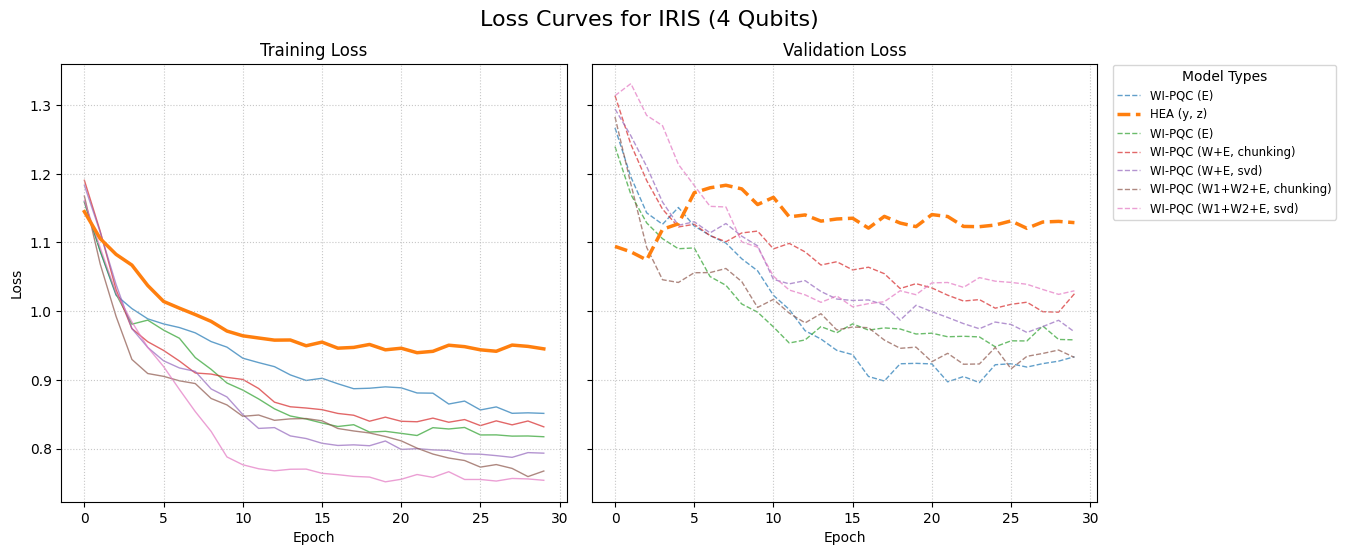


#################### RESULTS FOR IRIS (4 QUBITS) ####################
Train Accuracy | Validation Accuracy | Test Accuracy
WI-PQC (W1+W2+E, svd): 0.8636 | 0.4138 | 0.6667
WI-PQC (W1+W2+E, chunking): 0.8068 | 0.5517 | 0.6667
WI-PQC (E): 0.7727 | 0.5862 | 0.4667
WI-PQC (E): 0.7045 | 0.5862 | 0.5667
WI-PQC (W+E, svd): 0.6932 | 0.5862 | 0.6333
WI-PQC (W+E, chunking): 0.6250 | 0.4483 | 0.7000
HEA (y, z): 0.5795 | 0.3793 | 0.4333


In [ ]:
# plot_loss_results_horizontal(iris_results_2q, highlight_keyword="HEA")
plot_loss_results_horizontal(iris_results_4q, highlight_keyword="HEA")
print_expr(iris_results_4q)

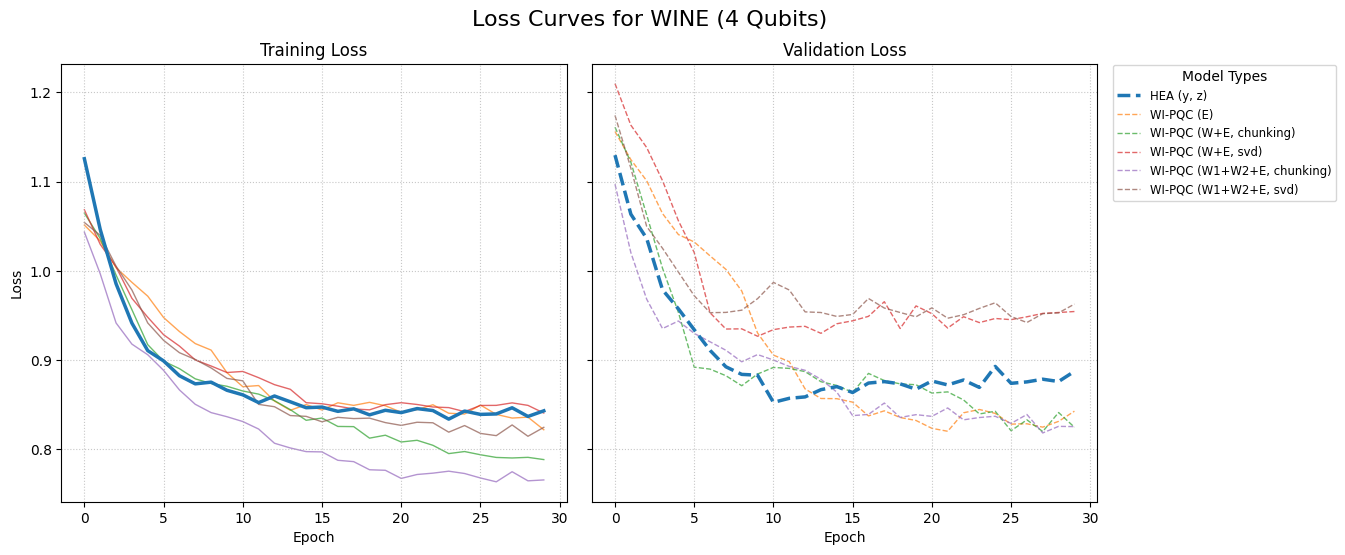

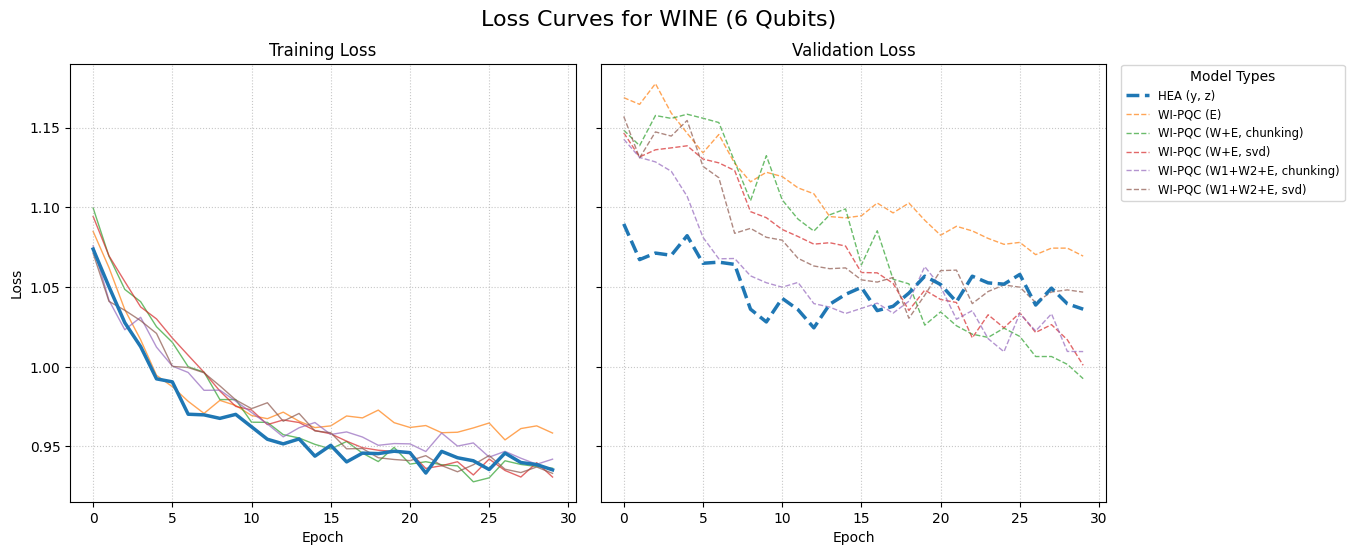

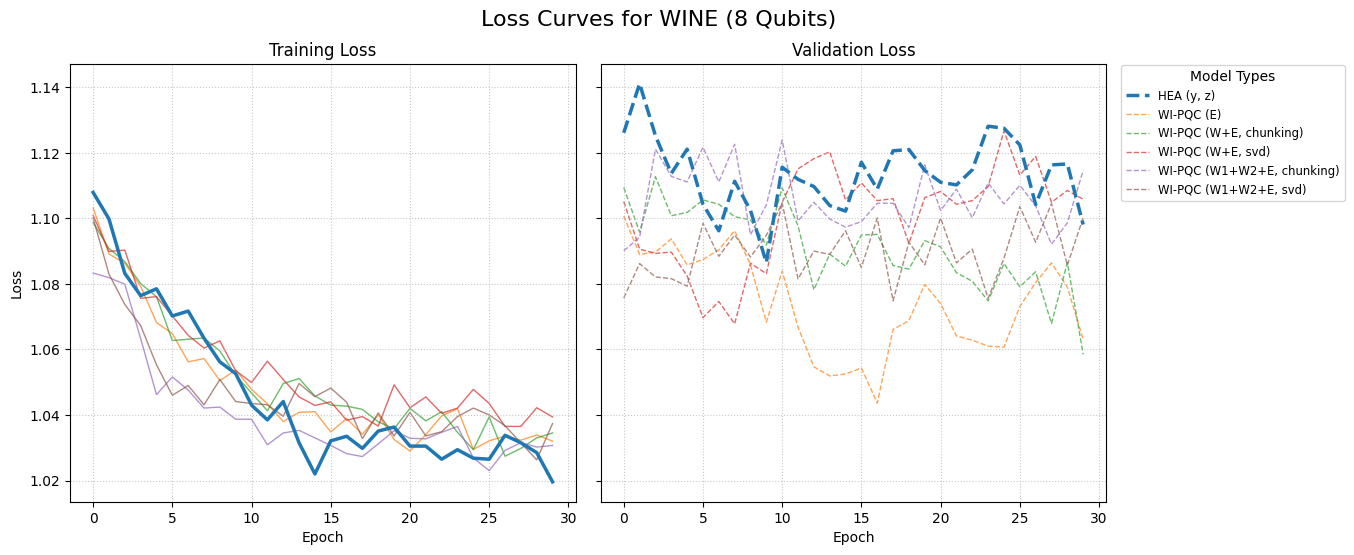

In [ ]:
# plot_loss_results_horizontal(wine_results_2q, highlight_keyword="HEA")
plot_loss_results_horizontal(wine_results_4q, highlight_keyword="HEA")
plot_loss_results_horizontal(wine_results_6q, highlight_keyword="HEA")
plot_loss_results_horizontal(wine_results_8q, highlight_keyword="HEA")

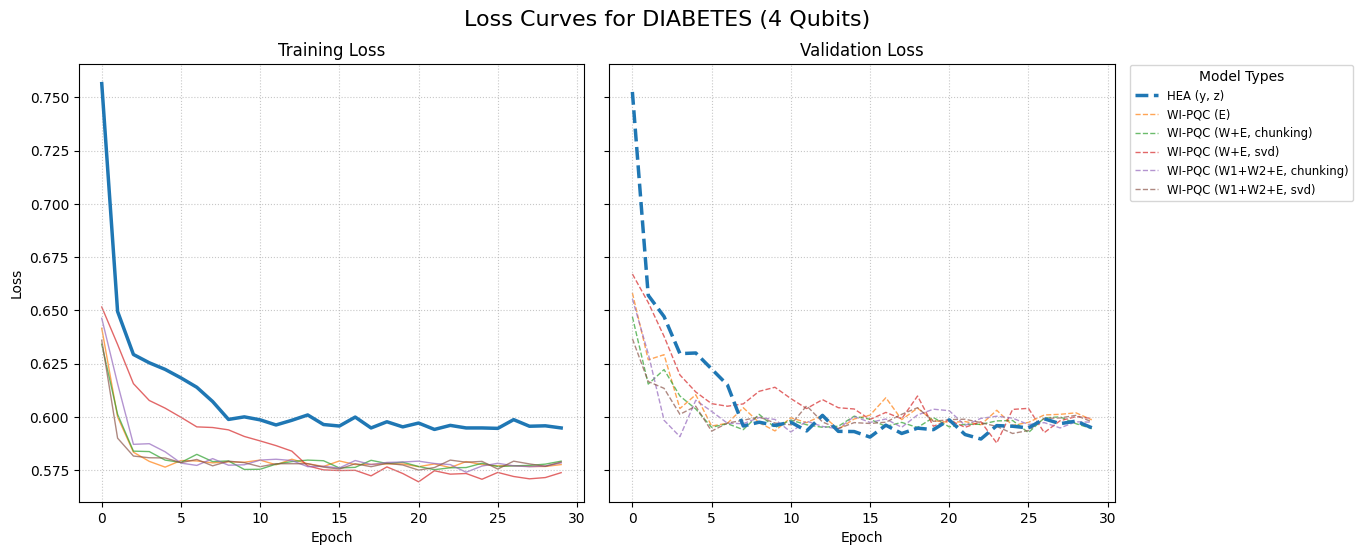

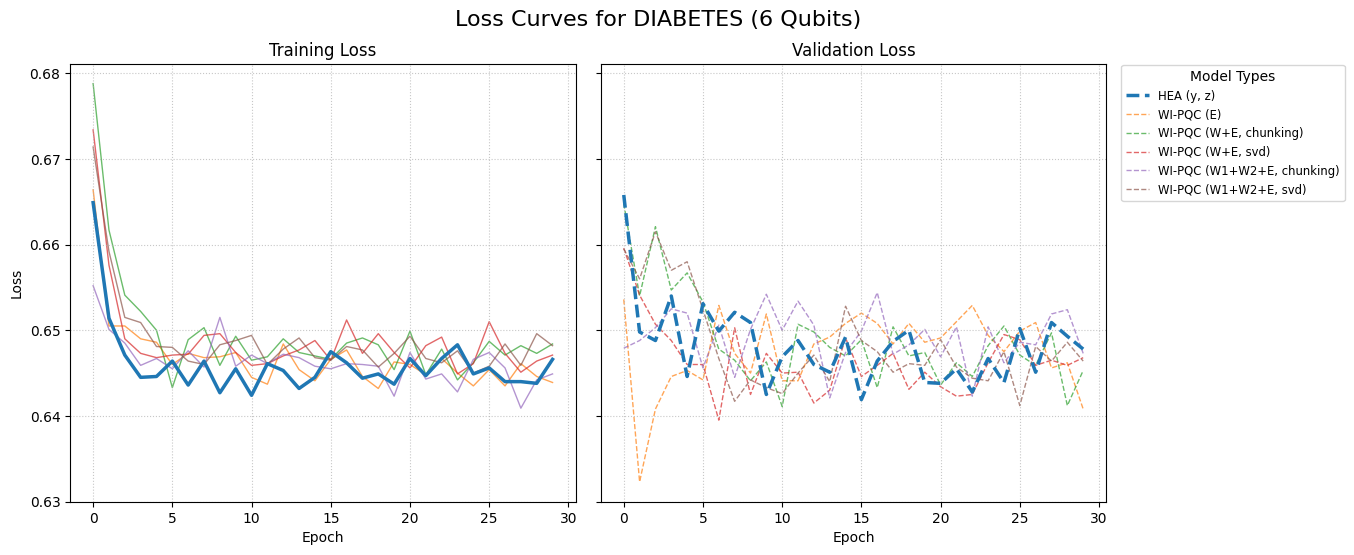

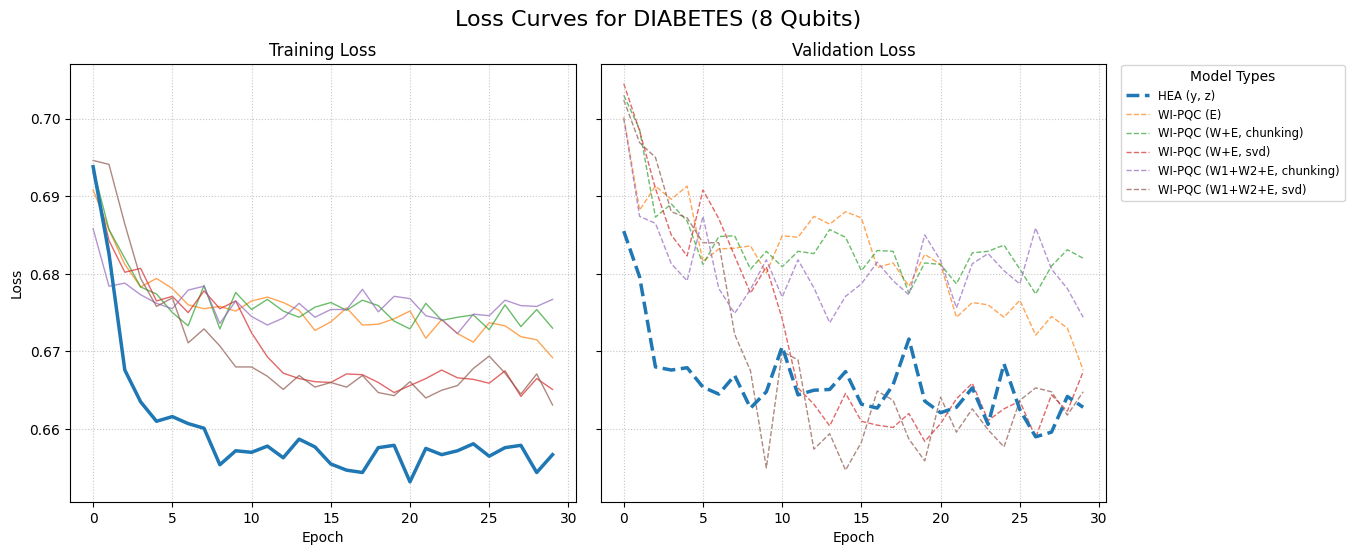

In [ ]:
# plot_loss_results_horizontal(diabetes_results_2q, highlight_keyword="HEA")
plot_loss_results_horizontal(diabetes_results_4q, highlight_keyword="HEA")
plot_loss_results_horizontal(diabetes_results_6q, highlight_keyword="HEA")
plot_loss_results_horizontal(diabetes_results_8q, highlight_keyword="HEA")

In [ ]:
# from utils.nn.ClassicalNN import ClassicalNN

# model_c = ClassicalNN(input_dim, hidden_dim=input_dim, output_dim=output_dim)
# optimizer_c = optim.Adam(model_c.parameters(), lr=0.01)

# start_time = time.time()
# model_c.fit(train_loader_c, val_loader_c, epochs=epochs_c, optimizer=optimizer_c, verbose=False)
# end_time = time.time()
# average_time_per_epoch = (end_time - start_time) / epochs_c


# test_metrics = model_c.evaluate(test_loader_c)
# print(f"Test Results: Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.4f}, F1={test_metrics[4]:.4f}")

# model_c.plot_history()

# test_loader_c_x = test_loader_c.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_c_x,
#     test_metrics[6],
#     test_metrics[5]
# )

In [ ]:
# from utils.ansatze.WIPQC import WeightInformedPQCAnsatz

# wi_ansatz = WeightInformedPQCAnsatz(classical_model=model_c, angle_scale_factor=0.1)
# wi_ansatz.draw()

     ┌───┐ H ┌──────────────────┐┌──────────────────┐┌──────────────────┐ Rot1.1       Ent1 ┌──────────────────┐ ┌──────────────────┐ ┌──────────────────┐ Rot1.2 ┌───────────────────┐┌───────────────────┐┌───────────────────┐ Rot2.1       Ent2 ┌───────────────────┐┌───────────────────┐┌───────────────────┐ Rot2.2 
q_0: ┤ H ├─░─┤ Rz(q0_rz_1.1_p0) ├┤ Ry(q0_ry_1.1_p1) ├┤ Rx(q0_rx_1.1_p2) ├───░──────■────░───┤ Rz(q0_rz_1.2_p6) ├─┤ Ry(q0_ry_1.2_p7) ├─┤ Rx(q0_rx_1.2_p8) ├───░────┤ Rz(q0_rz_2.1_p12) ├┤ Ry(q0_ry_2.1_p13) ├┤ Rx(q0_rx_2.1_p14) ├───░──────■────░───┤ Rz(q0_rz_2.2_p18) ├┤ Ry(q0_ry_2.2_p19) ├┤ Rx(q0_rx_2.2_p20) ├───░────
     ├───┤ ░ ├──────────────────┤├──────────────────┤├──────────────────┤   ░    ┌─┴─┐  ░   ├──────────────────┤┌┴──────────────────┤┌┴──────────────────┤   ░    ├───────────────────┤├───────────────────┤├───────────────────┤   ░    ┌─┴─┐  ░   ├───────────────────┤├───────────────────┤├───────────────────┤   ░    
q_1: ┤ H ├─░─┤ Rz(q1_rz_1.1_p3) ├┤ Ry(q1_ry_1.1_p4) 

In [ ]:
# from utils.nn.QuantumNN import QuantumNN
# from utils.ansatze.HEA import HEA

# hea_ansatz = HEA(n_qubits=input_dim, depth=2)
# model_hea = QuantumNN(ansatz=hea_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)

# hea_ansatz.draw()

     ┌──────────┐┌──────────┐                    ┌──────────┐┌───────────┐                                         ┌───────────┐┌───────────┐                          
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■────■─────────■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────────■────────■─────────■──┤ Ry(θ[16]) ├┤ Rz(θ[20]) ├──────────────────────────
     ├──────────┤├──────────┤┌─┴─┐  │         │  └──────────┘└┬──────────┤┌───────────┐    ┌─┴─┐      │         │  └───────────┘├───────────┤┌───────────┐             
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├──┼────■────┼───────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├────┤ X ├──────┼────■────┼────────■──────┤ Ry(θ[17]) ├┤ Rz(θ[21]) ├─────────────
     ├──────────┤├──────────┤└───┘┌─┴─┐┌─┴─┐  │       │       └──────────┘├───────────┤┌───┴───┴───┐┌─┴─┐┌─┴─┐  │        │      └───────────┘├───────────┤┌───────────┐
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├─────┤ X ├┤ X ├──┼───────┼────────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├┤ X ├┤ X ├──┼────────┼────────────■──────┤ Ry(θ[18]) ├┤ Rz(θ

In [ ]:
# from utils.ansatze.MPS import MPSAnsatz
# from utils.ansatze.TTN import TTNAnsatz

# mps_ansatz = MPSAnsatz(n_qubits=input_dim)
# mps_ansatz.draw()

# ttn_ansatz = TTNAnsatz(n_qubits=input_dim)
# ttn_ansatz.draw()


# model_mps = QuantumNN(ansatz=mps_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)
# model_ttn = QuantumNN(ansatz=ttn_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)


# circuit_fp, params_fp = AnsatzExtractor.extract_and_store_model_schema(ttn_ansatz, model_ttn, ".")
# qc, metadata = AnsatzExtractor.load_ansatz_from_model_schema(circuit_fp, params_fp)


ParameterView([ParameterVectorElement(θ_0_1[0]), ParameterVectorElement(θ_0_1[1]), ParameterVectorElement(θ_0_1[2]), ParameterVectorElement(θ_0_1[3]), ParameterVectorElement(θ_0_1[4]), ParameterVectorElement(θ_0_1[5]), ParameterVectorElement(θ_0_1[6]), ParameterVectorElement(θ_0_1[7]), ParameterVectorElement(θ_1_2[0]), ParameterVectorElement(θ_1_2[1]), ParameterVectorElement(θ_1_2[2]), ParameterVectorElement(θ_1_2[3]), ParameterVectorElement(θ_1_2[4]), ParameterVectorElement(θ_1_2[5]), ParameterVectorElement(θ_1_2[6]), ParameterVectorElement(θ_1_2[7]), ParameterVectorElement(θ_2_3[0]), ParameterVectorElement(θ_2_3[1]), ParameterVectorElement(θ_2_3[2]), ParameterVectorElement(θ_2_3[3]), ParameterVectorElement(θ_2_3[4]), ParameterVectorElement(θ_2_3[5]), ParameterVectorElement(θ_2_3[6]), ParameterVectorElement(θ_2_3[7])])
     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░                                                                                 ░

In [ ]:
qc.decompose().draw(fold=-1)

┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░                                                                                 ░ 
q_0: ┤ Ry(θ_0_1[0]) ├──■──┤ Ry(θ_0_1[2]) ├──■──┤ Ry(θ_0_1[4]) ├──■──┤ Ry(θ_0_1[6]) ├─░─────────────────────────────────────────────────────────────────────────────────░─
     ├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤ ░ ┌──────────────┐     ┌──────────────┐     ┌──────────────┐     ┌──────────────┐ ░ 
q_1: ┤ Ry(θ_0_1[1]) ├┤ X ├┤ Ry(θ_0_1[3]) ├┤ X ├┤ Ry(θ_0_1[5]) ├┤ X ├┤ Ry(θ_0_1[7]) ├─░─┤ Ry(θ_1_3[0]) ├──■──┤ Ry(θ_1_3[2]) ├──■──┤ Ry(θ_1_3[4]) ├──■──┤ Ry(θ_1_3[6]) ├─░─
     ├──────────────┤└───┘├──────────────┤└───┘├──────────────┤└───┘├──────────────┤ ░ └──────────────┘  │  └──────────────┘  │  └──────────────┘  │  └──────────────┘ ░ 
q_2: ┤ Ry(θ_2_3[0]) ├──■──┤ Ry(θ_2_3[2]) ├──■──┤ Ry(θ_2_3[4]) ├──■──┤ Ry(θ_2_3[6]) ├─░───────────────────┼────────────────────┼────────────────────┼───────────────────░─
     ├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤┌─┴─┐├──────────────┤ ░ ┌──────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌──────────────┐ ░ 
q_3: ┤ Ry(θ_2_3[1]) ├┤ X ├┤ Ry(θ_2_3[3]) ├┤ X ├┤ Ry(θ_2_3[5]) ├┤ X ├┤ Ry(θ_2_3[7]) ├─░─┤ Ry(θ_1_3[1]) ├┤ X ├┤ Ry(θ_1_3[3]) ├┤ X ├┤ Ry(θ_1_3[5]) ├┤ X ├┤ Ry(θ_1_3[7]) ├─░─
     └──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘ ░ └──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘ ░

In [ ]:
# model_hea = QuantumNN(ansatz=hea_ansatz.get_ansatz(), n_qubits=input_dim, num_classes=output_dim)

# optimizer_q = optim.Adam(model_hea.parameters(), lr=0.05)
# scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_q,
#     mode      = "min",
#     factor    = 0.3,
#     patience  = epochs_q//5,
#     min_lr    = 1e-4,
#     verbose   = True,
# )

# start_time = time.time()
# model_hea.fit(train_loader_q, val_loader_q, epochs=epochs_q, optimizer=optimizer_q, scheduler=scheduler_q)
# end_time = time.time()

# test_metrics_hea = model_hea.evaluate(test_loader_q)
# print(f"Test Results: Loss={test_metrics_hea[0]:.4f}, Acc={test_metrics_hea[1]:.4f}, F1={test_metrics_hea[4]:.4f}")

# model_hea.plot_history()

# test_loader_q_x = test_loader_q.dataset.tensors[0].numpy()
# plot_classification_results(
#     test_loader_q_x,
#     test_metrics_hea[6],
#     test_metrics_hea[5]
# )

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:59: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/2411793694.py:34: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler(options={"shots": 1024}) # shots-based simulation (approximate, fast, but introduces sampling noise)
/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/2411793694.py:35: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gradient = ParamShiftSamplerGradient(sampler) # for param shift rule (exact, slow)
/var/folders/dv/57s4jp9x1h1509smqvyknt5h0000gn/T/ipykernel_40545/241179

Test Results: Loss=0.7998, Acc=0.6667, F1=0.6366


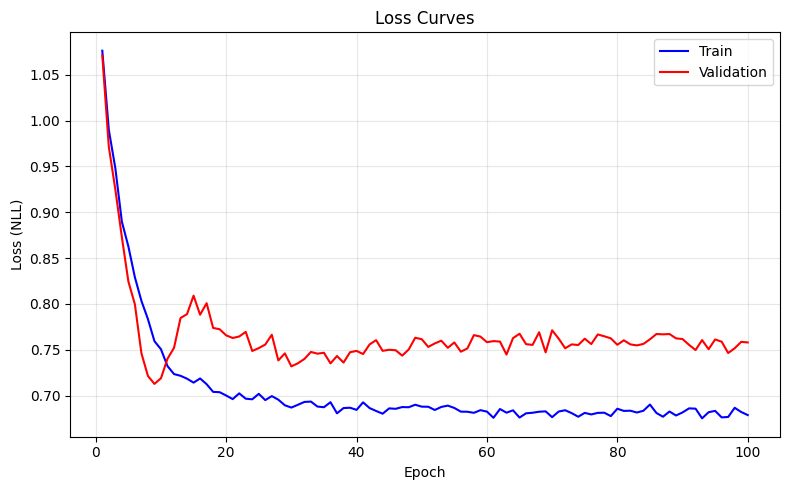

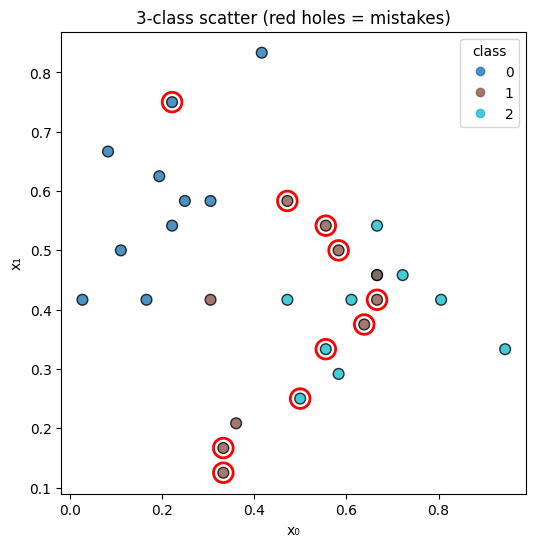

In [ ]:
# model_wi = QuantumNN(
#     ansatz=wi_ansatz.get_ansatz(),
#     initial_point=wi_ansatz.get_initial_point(),
#     n_qubits=input_dim,
#     num_classes=output_dim
# )

# optimizer_q = optim.Adam(model_wi.parameters(), lr=0.05)
# scheduler_q = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer_q,
#     mode      = "min",
#     factor    = 0.3,
#     patience  = epochs_q//5,
#     min_lr    = 1e-4,
#     verbose   = True,
# )

# start_time = time.time()
# model_wi.fit(train_loader_q, val_loader_q, epochs=epochs_q, optimizer=optimizer_q, scheduler=scheduler_q)
# end_time = time.time()

# test_metrics_wi = model_wi.evaluate(test_loader_q)
# print(f"Test Results: Loss={test_metrics_wi[0]:.4f}, Acc={test_metrics_wi[1]:.4f}, F1={test_metrics_wi[4]:.4f}")

# model_wi.plot_history()

# test_loader_q_x = test_loader_q.dataset.tensors[0].numpy()

# plot_classification_results(
#     test_loader_q_x,
#     test_metrics_wi[6],
#     test_metrics_wi[5]
# )

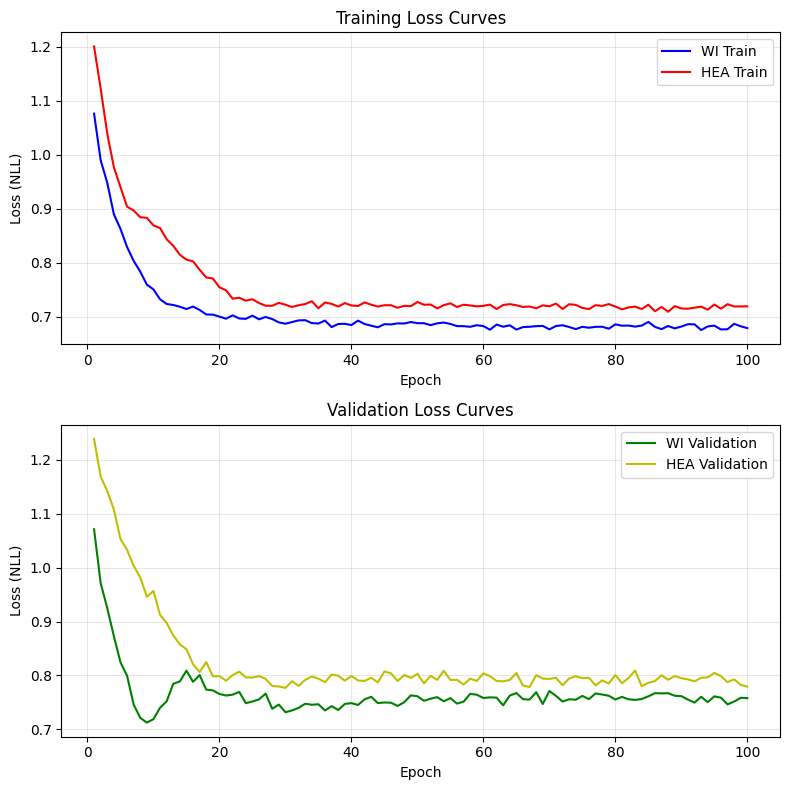

In [ ]:
# # plot test_metrics_wi and test_metrics_hea

# wi_train_loss = model_wi.history["train_loss"]
# wi_val_loss = model_wi.history["val_loss"]

# hea_train_loss = model_hea.history["train_loss"]
# hea_val_loss = model_hea.history["val_loss"]

# fig, ax = plt.subplots(2, 1, figsize=(8, 8))  # 2 rows, 1 column

# epochs = range(1, len(wi_train_loss) + 1)

# # WI loss curves
# ax[0].plot(epochs, wi_train_loss, 'b-', label="WI Train")
# ax[0].plot(epochs, hea_train_loss, 'r-', label="HEA Train")
# ax[0].set_xlabel("Epoch")
# ax[0].set_ylabel("Loss (NLL)")
# ax[0].set_title("Training Loss Curves")
# ax[0].legend()
# ax[0].grid(alpha=0.3)

# # HEA loss curves
# ax[1].plot(epochs, wi_val_loss, 'g-', label="WI Validation")
# ax[1].plot(epochs, hea_val_loss, 'y-', label="HEA Validation")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("Loss (NLL)")
# ax[1].set_title("Validation Loss Curves")
# ax[1].legend()
# ax[1].grid(alpha=0.3)

# plt.tight_layout()
# plt.show()
